In [2]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers
from sklearn.preprocessing import MinMaxScaler


In [3]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 



In [5]:
# Loading data

df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)

# Focusing on time data, setting index as timestamp

df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 
df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


## Building a forecasting model 

In [6]:

# Some quick code to set this up: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

In [7]:
# Split the data, 50% in training and 25% in validation, 25% in test, and not randomly selected since this is a time series

scaler = MinMaxScaler()

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.5))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.75))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_validation = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)


In [8]:
delay = 12
sequence_length = 36

train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

In [9]:
# Baseline

def evalute_naive_method(dataset):

    total_abs_err = 0
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1]
        total_abs_err += np.sum(np.abs(preds-targets))
        #print(preds, targets, total_abs_err)
        samples_seen += samples.shape[0]
    
    return total_abs_err / samples_seen

persistence_mae = evalute_naive_method(test) 

print(f'Baseline: persistence forecast for 1 hour - MAE: {persistence_mae*100:.2f}%')

Baseline: persistence forecast for 1 hour - MAE: 6.48%


2023-05-17 15:05:06.135252: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [475,1]
	 [[{{node Placeholder/_20}}]]
2023-05-17 15:05:06.135556: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [475]
	 [[{{node Placeholder/_8}}]]


## First LSTM model

In [10]:
inputs = keras.Input(shape=(36, 1))

x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=10,
                    validation_data=validation)


test_mae = model.evaluate(test)[1]
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

print(f'Test MAE :{test_mae}')


Epoch 1/10


2023-05-17 15:05:06.516965: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [998]
	 [[{{node Placeholder/_8}}]]
2023-05-17 15:05:06.517260: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [998,1]
	 [[{{node Placeholder/_20}}]]


991/998 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0485

2023-05-17 15:05:11.218607: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-05-17 15:05:11.218897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [475]
	 [[{{node Placeholder/_8}}]]


998/998 [==============================] - 5s 4ms/step - loss: 0.0050 - mae: 0.0484 - val_loss: 0.0059 - val_mae: 0.0644
Epoch 2/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0029 - mae: 0.0418 - val_loss: 0.0051 - val_mae: 0.0589
Epoch 3/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0026 - mae: 0.0385 - val_loss: 0.0053 - val_mae: 0.0617
Epoch 4/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0024 - mae: 0.0371 - val_loss: 0.0042 - val_mae: 0.0547
Epoch 5/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0020 - mae: 0.0340 - val_loss: 0.0036 - val_mae: 0.0494
Epoch 6/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0019 - mae: 0.0332 - val_loss: 0.0035 - val_mae: 0.0479
Epoch 7/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0019 - mae: 0.0333 - val_loss: 0.0035 - val_mae: 0.0477
Epoch 8/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0019 - mae:

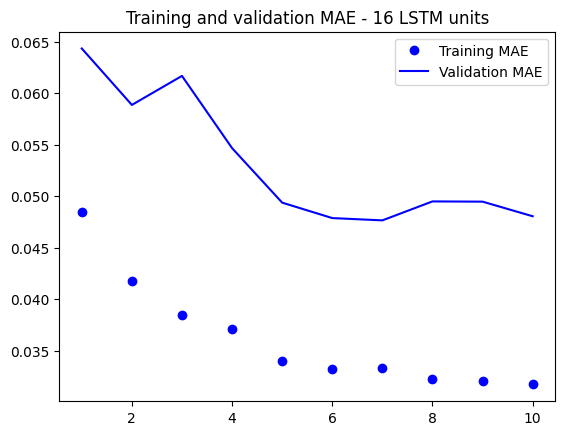

In [11]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

## Experimenting with different number of LSTM nodes

In [19]:
def try_lstm_n_nodes(n):

    inputs = keras.Input(shape=(36, 1))

    x = layers.LSTM(n)(inputs)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(train,
                        epochs=10,
                        validation_data=validation)

    
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)

    print(f'\n========= \
            \nCompleted run for n={n} nodes. \
            \n========= \
            \nFinal val_loss: {val_loss[-1]}' )
    return {'loss': loss, 'val_loss' : val_loss, 'epochs' : epochs}

results = {}

for i in [1,2,4,8,16,32]:

    results[f'{i}'] = try_lstm_n_nodes(i)

with open('lstm_node_experiments.pkl', 'wb') as f:
    pickle.dump(results, f)


Epoch 1/10
998/998 [==============================] - 5s 4ms/step - loss: 0.0474 - mae: 0.1276 - val_loss: 0.0107 - val_mae: 0.0836
Epoch 2/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0051 - mae: 0.0578 - val_loss: 0.0102 - val_mae: 0.0844
Epoch 3/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0048 - mae: 0.0561 - val_loss: 0.0097 - val_mae: 0.0811
Epoch 4/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0046 - mae: 0.0553 - val_loss: 0.0100 - val_mae: 0.0847
Epoch 5/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0044 - mae: 0.0540 - val_loss: 0.0090 - val_mae: 0.0785
Epoch 6/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0042 - mae: 0.0521 - val_loss: 0.0088 - val_mae: 0.0766
Epoch 7/10
998/998 [==============================] - 4s 4ms/step - loss: 0.0041 - mae: 0.0518 - val_loss: 0.0087 - val_mae: 0.0779
Epoch 8/10
998/998 [==============================] - 4s 4ms/step - loss: 0.

## Loading results and displaying training runs

In [20]:
with open('lstm_node_experiments.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

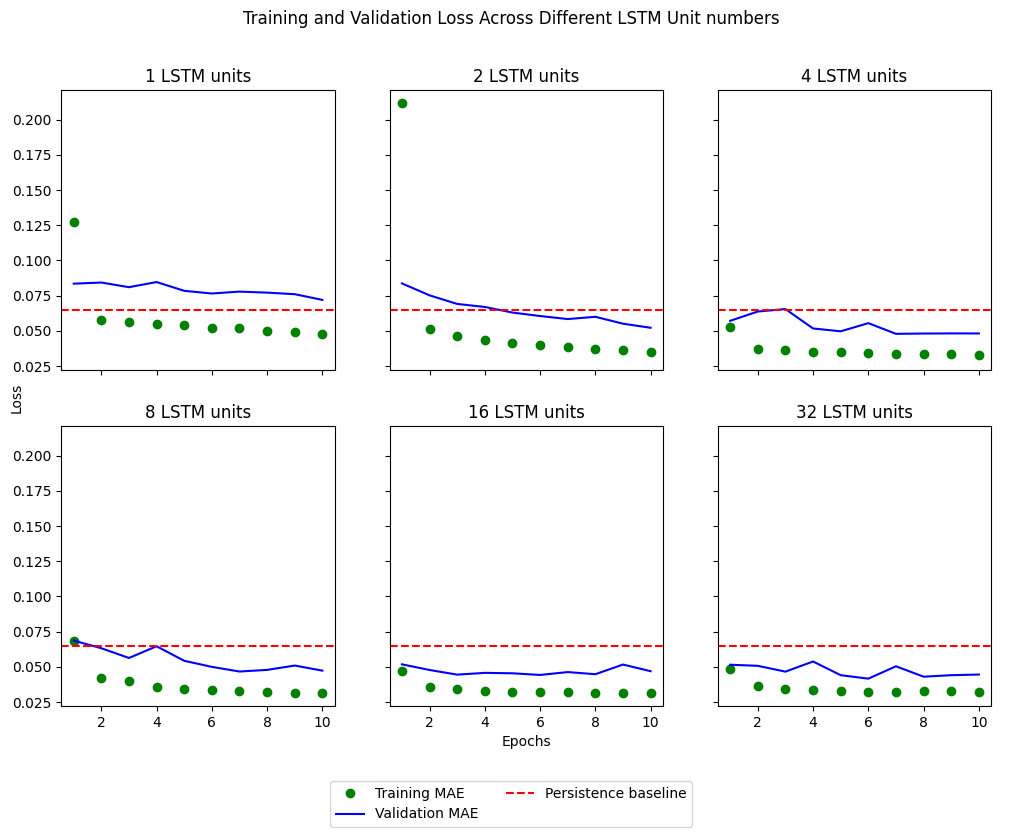

In [22]:
persistence_baseline = persistence_mae


# Create the figure and axes
fig, axes = plt.subplots(figsize=(12,8), nrows=2, ncols=3, sharex=True, sharey=True)

# Loop over the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    key = list(loaded_dict.keys())[i]

    epochs = loaded_dict[key]['epochs']
    loss = loaded_dict[key]['loss']
    val_loss = loaded_dict[key]['val_loss']

    ax.plot(epochs, loss, "go", label="Training MAE")
    ax.plot(epochs, val_loss, "b", label="Validation MAE")
    ax.axhline(y=persistence_baseline, color='r', linestyle='--', label='Persistence baseline')
    ax.set_title(f"{key} LSTM units")
    

# Add a common x-axis label and a common y-axis label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.xlabel("Epochs")
plt.ylabel("Loss")


# Add the legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

fig.suptitle("Training and Validation Loss Across Different LSTM Unit numbers")

# Display the figure
plt.show()
